In [1]:
import numpy as np
from astropy import table
import matplotlib.pyplot as plt
import csv
import matplotlib.colors as colours

### Prepare the data for training 

In [2]:
# Import table containing spectra of matched targets
csv.field_size_limit(100000000)
spectra = table.QTable.read('/home/jupyter-stephanielee/Neural networks/normalized spectra.ecsv')

In [3]:
# Import table containing metallicities of matched targets
matches = table.QTable.read('/home/jupyter-stephanielee/Neural networks/final match.ecsv')

In [4]:
# Turn the fluxes into an array, this is what we'll feed our network
X = np.array(spectra['flux'])

In [5]:
# Construct the target ndarray, this is what our network will compare its results to. The errors are used for chi-
# squared loss calculations
feh_target = np.array(matches['FE_H'])
feh_error = np.array(matches['FE_H_ERR'])
mgfe_target = np.array(matches['MG_FE'])
mgfe_error = np.array(matches['MG_FE_ERR'])
cfe_target = np.array(matches['C_FE'])
cfe_error = np.array(matches['C_FE_ERR'])
ofe_target = np.array(matches['O_FE'])
ofe_error = np.array(matches['O_FE_ERR'])
y = np.stack((feh_target, mgfe_target, ofe_target, cfe_target, feh_error,  mgfe_error, ofe_error, cfe_error), 
             axis = 1)

# 11 elements

### The network I used is only modified slightly from the one found here: https://machinelearningmastery.com/building-a-regression-model-in-pytorch/

In [6]:
# Define the model. My input is 9000 because that is the dimension of each flux array; it was just the number of
# points I arbitrarily chose to interpolate to. The architecture is ad hoc, I tinkered with it a bunch and this 
# was what gave me the best results. Playing with the number of layers and neurons, along with the activation  
# function, learning rate, number of training epochs, and batch size is likely necessary for different data to get
# the best results
import torch
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(9000, 9000),
    nn.GELU(), 
    nn.Linear(9000, 900),
    nn.GELU(),
    nn.Linear(900, 90),
    nn.GELU(),
    nn.Linear(90, 10),
    nn.GELU(),
    nn.Linear(10, 4))

In [7]:
# Define the chi-squared loss function. The 'y' and 'error' needs to be altered if your data is structured 
# differently
import torch.optim as optim

# loss function and optimizer
def loss_fn(output, target):
    y = target[:, :4] # 11
    error = target[:, 4:]
    chi2 = (output-y)**2 / error**2
    return torch.mean(chi2) # uncertainties need to be an array of all errors in batch
optimizer = optim.Adam(model.parameters(), lr = 1e-6) # 'lr' is the learning rate, Josh suggested starting from 
# 1e-4 and going smaller

In [8]:
%%time

import copy
import tqdm # gives progress bar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# train-test split of the dataset
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True) # 'train_size' is 
# the proportion of all data that you want to be the training set, the rest will be the test set

# Standardizing data
scaler = StandardScaler() # z = (x - x_bar) / stdev(x)
scaler.fit(X_train_raw) # applied after train-test split, fitted to training set but applied to both
X_train = scaler.transform(X_train_raw) # not applied to all data to prevent data leakage
X_test = scaler.transform(X_test_raw)

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# training parameters
n_epochs = 200   # number of epochs to run
batch_size = 192  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size) # returns 1D tensor of size ceil((end - start) / step)

# Hold the best model
best_chi2 = np.inf   # init to infinity
best_weights = None
history = []


# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit = "batch", mininterval = 0, disable = False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start + batch_size]
            y_batch = y_train[start:start + batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch) # loss of training batch
            # backward pass
            optimizer.zero_grad() # sets gradient to None
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(chi2 = float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    chi2 = loss_fn(y_pred, y_test) # loss of corresponding test batch 
    chi2 = float(chi2)
    history.append(chi2)
    if chi2 < best_chi2:
        best_chi2 = chi2
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
Epoch 110: 100%|██████████| 31/31 [00:01<00:00, 18.52batch/s, chi2=2.29]


Epoch 199: 100%|██████████| 31/31 [00:01<00:00, 25.00batch/s, chi2=0.913]


CPU times: user 7h 1min 19s, sys: 17min 2s, total: 7h 18min 21s
Wall time: 5min 47s


<All keys matched successfully>

Chi-squared: 14.38


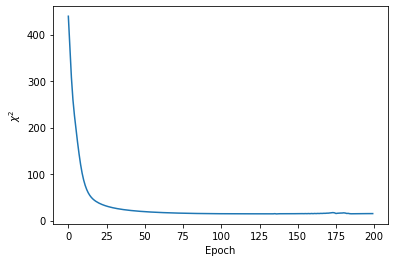

In [9]:
# Plot the progession of chi-squared loss over training epochs
print("Chi-squared: %.2f" % best_chi2)
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('$\chi^{2}$')
plt.show()

In [10]:
# Make lists of the expectations and predictions to use for plotting results
model.eval()
with torch.no_grad():
    feh_exp = [] # expected values from APOGEE
    feh_pred = [] # predicted values from the network
    mgfe_exp = []
    mgfe_pred = []
    cfe_exp = []
    cfe_pred = []
    ofe_exp = []
    ofe_pred = []
    for i in range(len(X_test_raw)):
        X_sample = X_test_raw[i: i + 1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype = torch.float32)
        y_pred = model(X_sample)
        feh_pred.append(y_pred[0][0])
        feh_exp.append(y_test[i][0]) #feh_exp
        mgfe_pred.append(y_pred[0][1])
        mgfe_exp.append(y_test[i][1])
        ofe_pred.append(y_pred[0][2])
        ofe_exp.append(y_test[i][2])
        cfe_pred.append(y_pred[0][3])
        cfe_exp.append(y_test[i][3])

### Plot [Mg/Fe] vs [Fe/H] from our network predictions

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

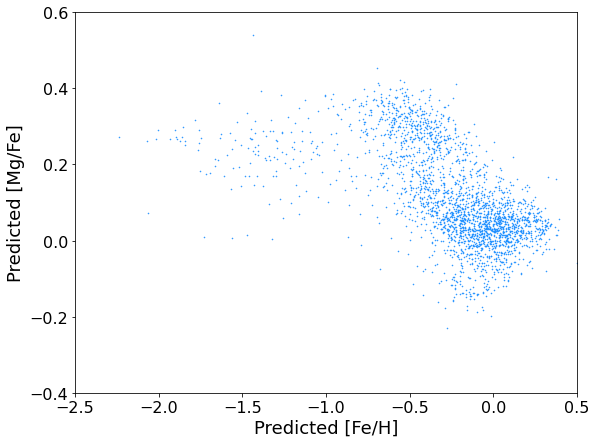

In [11]:
plt.figure(figsize = (9, 7))
plt.xlim(-2.5, 0.5)
plt.ylim(-0.4, 0.6)
plt.scatter(feh_pred, mgfe_pred, s = 0.3, c = 'dodgerblue')
plt.xlabel('Predicted [Fe/H]', fontsize = 18)
plt.ylabel('Predicted [Mg/Fe]', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

### Plot 2D histogram of residuals of metallicity vs metallicity 

In [12]:
# I created a custom colormap for my poster
cmap = colours.LinearSegmentedColormap.from_list('greenblue', ['white', 'dodgerblue', 'dodgerblue', 'royalblue', 
                                                               'royalblue', 'mediumblue', 'mediumblue', 
                                                               'midnightblue'])

Finding median and $\pm 1 \sigma$ for our network predictions

In [13]:
xbin = np.linspace(-2, 0.5, 100) # choose to focus on metallicity from -2 to 0.5
r = np.array(feh_pred) - np.array(feh_exp) # residuals of metallicity from network

In [14]:
print(np.mean(r))
print(np.median(r))

0.0015978013
0.0017961687


In [15]:
percentile_16 = np.percentile(r, 16)
percentile_84 = np.percentile(r, 84)
iqr_value = (percentile_84 - percentile_16) / 2
# Print or use the iqr_value as needed
print("Interquartile Range (IQR) of res:", iqr_value)
print("Standard deviation of res:", np.std(r))

Interquartile Range (IQR) of res: 0.04297243356704712
Standard deviation of res: 0.06650844


In [16]:
r1 = np.array(mgfe_pred) - np.array(mgfe_exp)
print(np.mean(r1))
print(np.median(r1))
percentile_16 = np.percentile(r1, 16)
percentile_84 = np.percentile(r1, 84)
iqr_value = (percentile_84 - percentile_16) / 2
# Print or use the iqr_value as needed
print("Interquartile Range (IQR) of res:", iqr_value)
print("Standard deviation of res:", np.std(r1))

-0.00047754688
-0.0003082268
Interquartile Range (IQR) of res: 0.03983402848243713
Standard deviation of res: 0.048629418


In [17]:
r2 = np.array(ofe_pred) - np.array(ofe_exp)
print(np.mean(r2))
print(np.median(r2))
percentile_16 = np.percentile(r2, 16)
percentile_84 = np.percentile(r2, 84)
iqr_value = (percentile_84 - percentile_16) / 2
# Print or use the iqr_value as needed
print("Interquartile Range (IQR) of res:", iqr_value)
print("Standard deviation of res:", np.std(r2))

0.005122338
0.0010522269
Interquartile Range (IQR) of res: 0.0767884574830532
Standard deviation of res: 0.10973612


In [18]:
r3 = np.array(cfe_pred) - np.array(cfe_exp)
print(np.mean(r3))
print(np.median(r3))
percentile_16 = np.percentile(r3, 16)
percentile_84 = np.percentile(r3, 84)
iqr_value = (percentile_84 - percentile_16) / 2
# Print or use the iqr_value as needed
print("Interquartile Range (IQR) of res:", iqr_value)
print("Standard deviation of res:", np.std(r3))

-0.004265494
-0.0055948794
Interquartile Range (IQR) of res: 0.05585122406482696
Standard deviation of res: 0.09703583


In [19]:
lower = [] # -1 sigma
median = []
upper = [] # +1 sigma
center = []
for n in range(len(xbin)-1):
    edges = [i for i in range(len(feh_exp)) if (feh_exp[i] >= xbin[n] and feh_exp[i] < xbin[n+1])]
    residual = [] 
    if edges:
        c = (xbin[n + 1] + xbin[n]) / 2 # find the center of the bins where I'll put my points 
        center.append(c)
        for k in edges:
            residual.append(r[k]) # append all the residuals 
        p = np.percentile(residual, (16, 50, 84)) # find where +-1 sigma and median are
        lower.append(p[0])
        median.append(p[1])
        upper.append(p[2])

In [20]:
# Interpolate values so we can plot lines on our 2D histogram
l = np.interp(xbin, center, lower) 
m = np.interp(xbin, center, median)
u = np.interp(xbin, center, upper)

Finding median and $\pm 1 \sigma$ for metallicity from DESI's RV pipeline

In [21]:
desi_feh = np.array(matches['FEH'])
xbin1 = np.linspace(-2, 0.5, 100)
r_desi = np.array(desi_feh) - np.array(feh_target)

In [22]:
lower1 = []
median1 = []
upper1 = []
center1 = []
for n in range(len(xbin1)-1):
    edges = [i for i in range(len(feh_exp)) if (feh_exp[i] >= xbin1[n] and feh_exp[i]< xbin1[n+1])]#feh_exp varies
    residual = []
    if edges:
        c = (xbin1[n+1] + xbin1[n])/2
        center1.append(c)
        for k in edges:
            residual.append(r_desi[k])
        p = np.percentile(residual, (16, 50, 84))
        lower1.append(p[0])
        median1.append(p[1])
        upper1.append(p[2])

In [23]:
l1 = np.interp(xbin1, center1, lower1)
m1 = np.interp(xbin1, center1, median1)
u1 = np.interp(xbin1, center1, upper1)

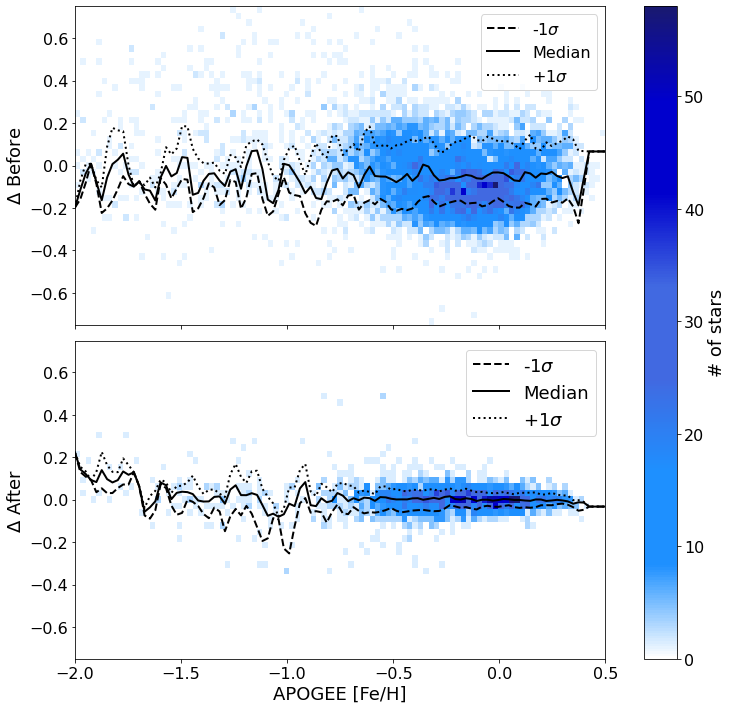

In [24]:
# Plot the 2D histograms! 
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,12))
ax1 = plt.subplot(2, 1, 1)
h1, x, y, i = plt.hist2d(feh_target, r_desi, bins = (np.linspace(-2, 0.5, 100), np.linspace(-0.75, 0.75, 50)), 
                         cmap = cmap)
plt.plot(xbin1, l1, c = 'black', linestyle = '--', label = '-1$\sigma$', lw = 2)
plt.plot(xbin1, m1, c = 'black', label = 'Median', lw = 2)
plt.plot(xbin1, u1, c = 'black', linestyle = 'dotted', label = '+1$\sigma$', lw = 2)

plt.ylabel('$\Delta$ Before', fontsize = 18)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
ax1.tick_params(axis = 'x', labelbottom=False)
im1 = ax1.imshow(h1, cmap = cmap)


ax2 = plt.subplot(2, 1, 2, sharex=ax1)
h2, x, y, i = plt.hist2d(feh_exp, r, bins = (np.linspace(-2, 0.5, 100), np.linspace(-0.75, 0.75, 50)), cmap = cmap)
plt.plot(xbin, l, c = 'black', linestyle = '--', label = '-1$\sigma$', lw = 2)
plt.plot(xbin, m, c = 'black', label = 'Median', lw = 2)
plt.plot(xbin, u, c = 'black', linestyle = 'dotted', label = '+1$\sigma$', lw = 2)

plt.xlabel('APOGEE [Fe/H]', fontsize = 18)
plt.ylabel('$\Delta$ After', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 18)
plt.subplots_adjust(hspace = 0.05)
im2 = ax2.imshow(h2, cmap = cmap)

cbar = fig.colorbar(im1, ax=(ax1, ax2))
cbar.ax.tick_params(labelsize = 16) 
cbar.set_label('# of stars', fontsize = 18)

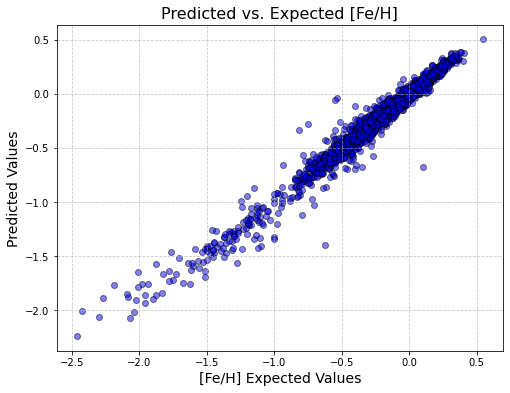

In [25]:
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

plt.scatter(feh_exp, feh_pred, alpha=0.5, color='b', edgecolors='k', marker='o')

plt.xlabel("[Fe/H] Expected Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)
plt.title("Predicted vs. Expected [Fe/H]", fontsize=16)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()